In [1]:
import os
import re
import ast
import glob
import json
import random
import cutlet
import argparse
import MeCab

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tqdm.notebook import tqdm
from convert_romaji import Romaji2Kana

from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Dense, 
    TimeDistributed)
from tensorflow.keras import mixed_precision

from transformers import (
    BertJapaneseTokenizer,
    TFBertModel,
    GradientAccumulator,
    logging)

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

def seed_everything(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    print("Random seed set.")

seed_everything(42)
tf.get_logger().setLevel('FATAL')
logging.set_verbosity_error()
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Random seed set.


In [2]:
def ArgParser():
    parser = argparse.ArgumentParser()

    # Dataset
    parser.add_argument("--main_dir", default="E://Datasets/Decoder_model")
    parser.add_argument("--random_state", default=42)
    parser.add_argument("--n_shards", default=20)
    parser.add_argument("--n_samples", default=2500000)
    parser.add_argument("--test_size", default=0.4)
    parser.add_argument("--vocab_size", default=6144)
    parser.add_argument("--batch_size", default=64)
    parser.add_argument("--buffer_size", default=1024)

    # Scheduler
    parser.add_argument("--epochs", default=5)
    parser.add_argument("--learning_rate", default=1e-8)
    parser.add_argument("--lr_start", default=1e-10)
    parser.add_argument("--lr_min", default=1e-10)
    parser.add_argument("--lr_max", default=1e-8)
    parser.add_argument("--n_cycles", default=0.5)
    parser.add_argument("--warmup_epochs", default=0)
    parser.add_argument("--sustain_epochs", default=0)

    args = parser.parse_known_args()[0]

    n_train = int(args.n_samples * (1 - args.test_size))
    n_val = int(args.n_samples * args.test_size)
    train_steps = int(np.ceil(n_train / args.batch_size))
    val_steps = int(np.ceil(n_val / args.batch_size))
    
    # Trainer
    parser.add_argument("--n_train", default=n_train)
    parser.add_argument("--n_val", default=n_val)
    parser.add_argument("--train_steps", default=train_steps)  
    parser.add_argument("--val_steps", default=val_steps)

    return parser.parse_known_args()[0]

args = ArgParser()
args

Namespace(batch_size=64, buffer_size=1024, epochs=5, learning_rate=1e-08, lr_max=1e-08, lr_min=1e-10, lr_start=1e-10, main_dir='E://Datasets/Decoder_model', n_cycles=0.5, n_samples=2500000, n_shards=20, n_train=1500000, n_val=1000000, random_state=42, sustain_epochs=0, test_size=0.4, train_steps=23438, val_steps=15625, vocab_size=6144, warmup_epochs=0)

# Data Preparation

In [3]:
class BertDataset:
    def __init__(self):
        self.main_dir = "D:\School-stuff\Sem-2\PR-Project\HoloASR\Datasets"
        opus_ja_paths = glob.glob(f"{self.main_dir}\OPUS100-dataset\*.ja")
        tatoeba_ja_paths = glob.glob(f"{self.main_dir}\Tatoeba-dataset\*.ja")
        self.jesc_path = f"{self.main_dir}/JESC-dataset/raw"
        self.ja_paths = opus_ja_paths + tatoeba_ja_paths
        self.kanji_unicode = self.get_kanji_unicode()
        self.katsu = cutlet.Cutlet()
        self.katsu.use_foreign_spelling = False

        tqdm.pandas()
        self.data = pd.DataFrame({"raw_text": self.get_data()})

        # Remove rows that contains non-kanji characters
        self.data = self.data[self.data['raw_text'].progress_apply(self.check_kanji)]   

        # Remove words within parenthesis
        parenthesis =  r"\（.*\）|\(.*\)|\「.*\」|\『.*\』"
        self.data = self.data[~self.data['raw_text'].str.contains(parenthesis)]

        # Remove punctuations from sentences
        self.data['raw_text'] = self.data['raw_text'].progress_apply(self.clean_kanji)

        # Converts kanji to hiragana sentences
        self.data['hira_text'] = self.data['raw_text'].progress_apply(self.kanji2hira)

        # Remove null rows
        self.data = self.data[~(self.data['raw_text']=="") | ~(self.data['hira_text']=="")]
        self.data = self.data.dropna().reset_index(drop=True)

        # Generate vocab file
        self.vocab_file = r"E:\Datasets\Language_model\bert_vocab.txt"
        self.get_vocab(self.data)

        # Construct tokenizer
        self.tokenizer = BertJapaneseTokenizer(
            vocab_file=self.vocab_file,
            do_lower_case=False,
            do_word_tokenize=False,
            do_subword_tokenize=True,
            word_tokenizer_type="mecab",
            subword_tokenizer_type="character")

        # Tokenize inputs and labels
        self.data['input_ids'] = self.data['hira_text'].progress_apply(
            lambda x: self.tokenizer(x).input_ids)
        self.data['label_ids'] = self.data['raw_text'].progress_apply(
            lambda x: self.tokenizer(x).input_ids)

        # Apply padding to either input or labels to same length
        new_input_ids, new_label_ids = [], []
        for row_idx in tqdm(range(len(self.data)), total=len(self.data)):
            input_ids, label_ids = self.pad_longest(row_idx)
            new_input_ids.append(input_ids)
            new_label_ids.append(label_ids)

        self.data['input_ids'] = new_input_ids
        self.data['label_ids'] = new_label_ids
        self.data['input_len'] = self.data['input_ids'].apply(len)

        # Remove rows that has unknown tokens
        self.data = self.data[~self.data['input_ids'].apply(
            lambda x: self.tokenizer.unk_token_id in x)]
        self.data = self.data[~self.data['label_ids'].apply(
            lambda x: self.tokenizer.unk_token_id in x)]
        self.data.reset_index(drop=True, inplace=True)

        # Save to csv
        self.data.to_csv(
            r"E:\Datasets\Language_model\bert_data.csv", 
            encoding="utf-8", index=False)

    def get_kanji_unicode(self):
        vocab = set()
        with open(f"{self.main_dir}\kanji_unicode.txt", encoding="utf-8") as f:
            lines = f.readlines()
            for line in lines:
                for char in line.split()[1:]:
                    vocab.add(char)
        return "|".join(sorted(vocab))

    def get_data(self):
        ja_lines = []
        for ja_path in self.ja_paths:
            with open(ja_path, "r", encoding="utf-8") as f:
                for line in f.readlines():
                    line = line.strip("\n| ")
                    ja_lines.append(line)
        with open(self.jesc_path, "r", encoding="utf-8") as f:
            texts = [text.split("\t") for text in f.readlines()]
            for _, line in texts:
                line = line.strip("\n| ")
                ja_lines.append(line)
        return ja_lines

    def check_kanji(self, sentence):
        pattern = f"[^{self.kanji_unicode}]"
        if re.match(pattern, sentence) == None:
            return True
        else:
            return False
    
    def clean_kanji(self, sentence):
        sentence = "".join(sentence.split())
        pattern = r"[・\。\！\.\？\、]"
        sentence = re.sub(pattern, "", sentence)
        return sentence

    def kanji2hira(self, sentence):
        try:
            sentence = self.katsu.romaji(sentence)
            sentence = sentence.replace(" ", "").lower()
            sentence = Romaji2Kana(sentence)
        except:
            sentence = None
        return sentence

    def get_vocab(self, data):
        vocab = []
        texts = data['raw_text'].tolist() + data['hira_text'].tolist()
        for text in tqdm(texts):
            for char in text:
                vocab.append(char)

        tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]
        
        for i in Counter(vocab).most_common():
            if i[0] in self.kanji_unicode:
                tokens.append(i[0])
            else:
                continue

        with open(self.vocab_file, "w", encoding="utf-8") as f:
            for token in tokens[:args.vocab_size]:
                f.write(token + "\n")    

    def pad_longest(self, row):
        input_len = len(self.data['input_ids'][row])
        label_len = len(self.data['label_ids'][row])
        input_ids = self.data['input_ids'][row]
        label_ids = self.data['label_ids'][row]
        if label_len > input_len:
            pad_width = label_len - input_len
            input_ids = np.pad(
                self.data['input_ids'][row], pad_width=(0, pad_width)).tolist()
        elif label_len < input_len:
            pad_width = input_len - label_len
            label_ids = np.pad(
                self.data['label_ids'][row], pad_width=(0, pad_width)).tolist()
        return input_ids, label_ids

# data = BertDataset().data
# data

# Data Loading

In [4]:
class TFRWriter():
    def __init__(self, args):
        self.args = args
        self.data = self.get_data()

    def get_data(self):
        tqdm.pandas()
        data = pd.read_csv(f"{self.args.main_dir}/bert_data.csv")
        data = data.dropna().reset_index(drop=True)
        data['input_ids'] = data['input_ids'].progress_apply(ast.literal_eval)
        data['label_ids'] = data['label_ids'].progress_apply(ast.literal_eval)
        data = data.query(f"input_len <= {data['input_len'].quantile(0.90)}")
        data = data.sample(n=self.args.n_samples, random_state=self.args.random_state)
        data = data.sort_values(by="input_len", ascending=True, ignore_index=True)
        return data[['input_ids', 'label_ids']]

    def _bytes_feature(self, value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    def serialize_example(self, *args):
        feature = {
            'input_ids': self._bytes_feature(args[0]),
            'attention_mask': self._bytes_feature(args[1]),
            'label_ids': self._bytes_feature(args[2])}

        example_proto = tf.train.Example(
            features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()

    def get_shards(self):
        skf = KFold(n_splits=self.args.n_shards, shuffle=False)
        return [j for i,j in skf.split(self.data)]

    def get_shard_data(self, samples):
        for sample in samples:
            input_ids = tf.convert_to_tensor(
                self.data['input_ids'][sample], dtype=tf.int32)
            attention_mask = tf.where(input_ids != 0, x=1, y=0)
            label_ids = tf.convert_to_tensor(
                self.data['label_ids'][sample], dtype=tf.int32)
            yield {
                "input_ids": tf.io.serialize_tensor(input_ids),
                "attention_mask": tf.io.serialize_tensor(attention_mask),
                "label_ids": tf.io.serialize_tensor(label_ids)}

    def write(self):
        for shard, samples in tqdm(enumerate(self.get_shards()), total=self.args.n_shards):
            with tf.io.TFRecordWriter(f"{self.args.main_dir}/bert_tfrec/shard_{shard+1}.tfrec") as f:
                for sample in self.get_shard_data(samples):
                    example = self.serialize_example(
                        sample['input_ids'],
                        sample['attention_mask'],
                        sample['label_ids'])
                    f.write(example)

# TFRWriter(args).write()

In [5]:
class DataLoader:
    def __init__(self, args):
        self.files = glob.glob(args.main_dir + "/bert_tfrec/*.tfrec")
        self.args = args
        self.AUTOTUNE = tf.data.AUTOTUNE
        self.train_files, self.val_files = train_test_split(
            self.files, test_size=args.test_size, shuffle=True,
            random_state=args.random_state)
        self.train = self.get_train()
        self.val = self.get_val()

    def read_tfrecord(self, example):
        feature_description = {
            'input_ids': tf.io.FixedLenFeature([], tf.string),
            'attention_mask': tf.io.FixedLenFeature([], tf.string),
            'label_ids': tf.io.FixedLenFeature([], tf.string)}
        
        example = tf.io.parse_single_example(example, feature_description)
        example['input_ids'] = tf.io.parse_tensor(
            example['input_ids'], out_type=tf.int32)
        example['attention_mask'] = tf.io.parse_tensor(
            example['attention_mask'], out_type=tf.int32) 
        example['label_ids'] = tf.io.parse_tensor(
            example['label_ids'], out_type=tf.int32)
        return example

    def load_dataset(self, files):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(self.read_tfrecord, num_parallel_calls=self.AUTOTUNE)
        return dataset

    def get_train(self):
        dataset = self.load_dataset(self.train_files)
        dataset = dataset.padded_batch(
            self.args.batch_size,
            padded_shapes={
                'input_ids': [None],
                'attention_mask': [None],
                'label_ids': [None]},
            padding_values={
                'input_ids': tf.constant(0, dtype=tf.int32),
                'attention_mask': tf.constant(0, dtype=tf.int32),
                'label_ids': tf.constant(0, dtype=tf.int32)})        
        dataset = dataset.shuffle(self.args.buffer_size)
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

    def get_val(self):
        dataset = self.load_dataset(self.val_files)
        dataset = dataset.padded_batch(
            self.args.batch_size,
            padded_shapes={
                'input_ids': [None],
                'attention_mask': [None],
                'label_ids': [None]},
            padding_values={
                'input_ids': tf.constant(0, dtype=tf.int32),
                'attention_mask': tf.constant(0, dtype=tf.int32),
                'label_ids': tf.constant(0, dtype=tf.int32)})
        dataset = dataset.shuffle(self.args.buffer_size)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset

# train = DataLoader(args).train
# inputs = next(iter(train))
# print("input_ids shape:", inputs['input_ids'].shape)
# print("attention_mask shape:", inputs['attention_mask'].shape)
# print("label_ids shape:", inputs['label_ids'].shape)

# Model Training

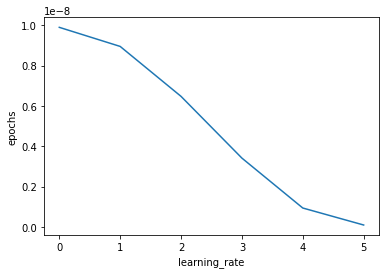

In [6]:
class CERMetric(tf.keras.metrics.Metric):
    def __init__(self, name="CER", **kwargs):
        super(CERMetric, self).__init__(name=name,  **kwargs)
        self.accumulator = self.add_weight(name="total_cer", initializer="zeros")
        self.counter = self.add_weight(name="cer_count", initializer="zeros")    

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        hypothesis = tf.cast(tf.sparse.from_dense(y_pred), dtype=tf.int32)

        # Convert dense to sparse tensor for edit_distance function
        truth = tf.RaggedTensor.from_tensor(y_true, padding=0).to_sparse()

        # Calculate Levenshtein distance
        distance = tf.edit_distance(hypothesis, truth, normalize=True)

        # Add distance and number of samples to variables
        self.accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(len(y_true))

    def result(self):
        # Divides accumulated distance scores against number of samples passed,
        # mimics mean reduction over batch
        return tf.math.divide_no_nan(self.accumulator, self.counter)   
    
    def reset_state(self):
        self.accumulator.assign(0.0)
        self.counter.assign(0.0)

class CosineDecayWithWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, args):
        self.args = args

    def __call__(self, epoch):  
        if epoch < self.args.warmup_epochs:
            lr = ((self.args.lr_max - self.args.lr_start) / self.args.warmup_epochs) * epoch + self.args.lr_start
        elif epoch < (self.args.warmup_epochs + self.args.sustain_epochs):
            lr = self.args.lr_max
        else:
            progress = ((epoch - self.args.warmup_epochs - self.args.sustain_epochs) / 
            (self.args.epochs - self.args.warmup_epochs - self.args.sustain_epochs))
            lr = (self.args.lr_max-self.args.lr_min) * (0.5 * (1.0 + tf.math.cos((22/7) * 
                self.args.n_cycles * 2.0 * progress)))
            if self.args.lr_min is not None:
                lr = tf.math.maximum(self.args.lr_min, lr)
        return lr

    def plot(self):
        epochs = range(self.args.epochs+1)
        lr = [self(epoch) for epoch in epochs]
        plt.plot(epochs, lr)
        plt.xlabel("learning_rate")
        plt.ylabel("epochs")
        plt.show()

CosineDecayWithWarmup(args).plot()

In [7]:
class Trainer:
    def __init__(self, args):
        self.args = args
        self.train_dataset = DataLoader(args).train
        self.val_dataset = DataLoader(args).val

        self.tokenizer = BertJapaneseTokenizer(
            vocab_file=f"{self.args.main_dir}/bert_vocab.txt",
            do_lower_case=False,
            do_word_tokenize=False,
            do_subword_tokenize=True,
            word_tokenizer_type="mecab",
            subword_tokenizer_type="character")
        
        self.model = self.Kana2Kanji(args)
        
        self.optimizer = tf.keras.optimizers.Adam(CosineDecayWithWarmup(args))
        self.loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False)
        self.cer_metric = CERMetric()

        self.model_name = f"model_{int(self.args.n_samples/1000)}k"
        self.log_path = f"{self.args.main_dir}/bert_model_weights/{self.model_name}.csv"
        if not os.path.exists(self.log_path):
            print("Log file created.")
            columns = "epoch,loss,cer,val_loss,val_cer\n"
            with open(self.log_path, "a") as f:
                f.write(columns)

    def Kana2Kanji(self, args):
        input_ids = Input(type_spec=tf.TensorSpec(
            shape=(args.batch_size, None), dtype=tf.int32), name="input_ids")
        mask = Input(type_spec=tf.TensorSpec(
            shape=(args.batch_size, None), dtype=tf.int32), name="attention_mask")

        bert = TFBertModel.from_pretrained(
            "cl-tohoku/bert-base-japanese-char",
            output_hidden_states=False,
            output_attentions=False,
            # num_hidden_layers=20,
            name="bert_model")

        x = bert(input_ids=input_ids, attention_mask=mask).last_hidden_state
        x = TimeDistributed(Dense(args.vocab_size, activation="softmax"), name="output")(x, mask=mask)

        return tf.keras.Model(inputs=[input_ids, mask], outputs=x, name="Kana2Kanji")

    def decoder(self, labels, logits):
        labels = self.tokenizer.batch_decode(labels, skip_special_tokens=True)
        logits = tf.argmax(logits, axis=-1)
        logits = self.tokenizer.batch_decode(logits, skip_special_tokens=True)
        return labels, logits

    def display(self, epoch, t_labels, t_logits, v_labels, v_logits):
        print("-" * 129)
        print("Training")
        for y_true, y_pred in zip(t_labels[:4], t_logits[:4]):
            print(f"Target:    {y_true.replace(' ', '')}")
            print(f"Predicted: {y_pred.replace(' ', '')}") 

        print("\nValidation")
        for y_true, y_pred in zip(v_labels[:4], v_logits[:4]):
            print(f"Target:    {y_true.replace(' ', '')}")
            print(f"Predicted: {y_pred.replace(' ', '')}")
        print("-" * 129)
        
    def fit(self):
        # Checkpointing
        self.ckpt_dir = f"{self.args.main_dir}/bert_checkpoints"
        self.ckpt = tf.train.Checkpoint(self.model)
        self.ckpt_manager = tf.train.CheckpointManager(
            checkpoint=self.ckpt, directory=self.ckpt_dir, max_to_keep=5)

        if self.ckpt_manager.latest_checkpoint:
            self.start_epoch = int(self.ckpt_manager.latest_checkpoint.split("-")[-1])
            self.ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print(f"Resuming from epoch {self.start_epoch + 1}...")
        else:
            self.start_epoch = 0
            print("Starting from epoch 1...")

        for epoch in range(self.start_epoch, self.args.epochs+1):
            print(f"Epoch {epoch+1}/{self.args.epochs}: Learning rate @ {self.optimizer.lr(epoch):.2e}")
            stateful_metrics = ["loss", "cer", "val_loss", "val_cer"]
            progbar = tf.keras.utils.Progbar(
                self.args.train_steps, interval=0.05,
                stateful_metrics=stateful_metrics)

            # Training loop
            for step, t_batch in enumerate(self.train_dataset):
                t_input_ids = t_batch['input_ids']
                t_attention_mask = t_batch['attention_mask']
                t_labels = t_batch['label_ids']
                with tf.GradientTape() as tape:
                    t_logits = self.model(
                        [t_input_ids, t_attention_mask],
                        training=True)
                    t_loss = self.loss_fn(
                        t_labels, t_logits, sample_weight=t_attention_mask)
                self.cer_metric.update_state(t_labels, t_logits)
                gradients = tape.gradient(t_loss, self.model.trainable_weights)
                self.optimizer.apply_gradients(zip(gradients, self.model.trainable_weights))
                t_cer = self.cer_metric.result()
                t_values = [("loss", t_loss), ("cer", t_cer)]
                progbar.update(step, values=t_values, finalize=False)
            
            t_labels, t_logits = self.decoder(t_labels, t_logits)
            self.cer_metric.reset_state()

            # Validation loop
            for v_batch in self.val_dataset:
                v_input_ids = v_batch['input_ids']
                v_attention_mask = v_batch['attention_mask']
                v_labels = v_batch['label_ids']
                v_logits = self.model(
                    [v_input_ids, v_attention_mask],
                    training=False)
                v_loss = self.loss_fn(
                    v_labels, v_logits, sample_weight=v_attention_mask)
                self.cer_metric.update_state(v_labels, v_logits)
            v_labels, v_logits = self.decoder(v_labels, v_logits)
            v_cer = self.cer_metric.result()
            v_values = [
                ("loss", t_loss),
                ("cer", t_cer),
                ("val_loss", v_loss),
                ("val_cer", v_cer)]
            progbar.update(self.args.train_steps, values=v_values, finalize=True)
            self.cer_metric.reset_state()

            # Print sample transcriptions for both loops
            self.display(epoch, t_labels, t_logits, v_labels, v_logits)

            # Checkpointing
            self.ckpt.save(file_prefix=f"{self.ckpt_dir}/{self.model_name}")

            # Logging
            log = f"{epoch+1},{t_loss},{t_cer},{v_loss},{v_cer}\n"
            with open(self.log_path, "a") as f:
                f.write(log)

            save_path = f"{self.args.main_dir}/bert_model_weights"
            self.model.save_weights(f"{save_path}/{self.model_name}_{epoch+1}.h5")

Trainer(args).fit()

Resuming from epoch 2...
Epoch 2/5: Learning rate @ 8.95e-09
23438/23438 [==============================] - 7436s 317ms/step - loss: 0.4693 - cer: 0.1515 - val_loss: 0.5806 - val_cer: 0.1329
---------------------------------------------------------------------------------------------------------------------------------
Training
Target:    これまで見たものから仮定してみよう
Predicted: これまで見たものから家定してみよう
Target:    何もお返しするものがないからって
Predicted: 何もお返しするものがないからって
Target:    彼が外出してるほうがいいのよ
Predicted: 彼が外出してる方がいいのよ
Target:    早樹は講義よりベルリッツだって
Predicted: 早野は講義よりベルリッツだって

Validation
Target:    彼の骨は壊れやすかったから
Predicted: 彼の骨は壊れやすかかか
Target:    注意したが体を壊した
Predicted: 注意したが体を壊した
Target:    工事現場そのものだけでなく
Predicted: 浩時現場そのものだけでなく
Target:    強力な酸で溶かすんだ
Predicted: 協力なさんでかすんだ
---------------------------------------------------------------------------------------------------------------------------------
Epoch 3/5: Learning rate @ 6.48e-09
23437/23438 [============================>.] - ETA: 0s - loss: 0.5377 - cer: 0.1376